### Import 

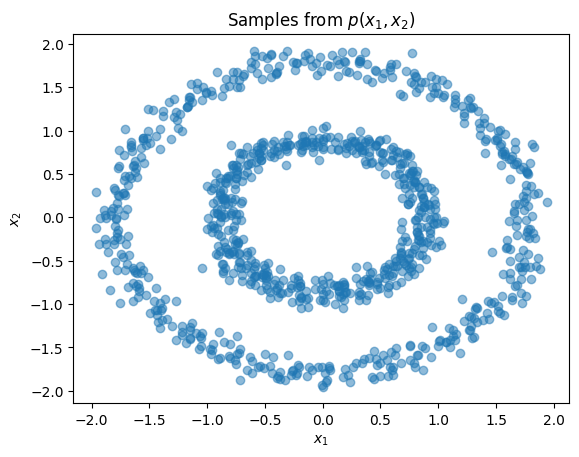

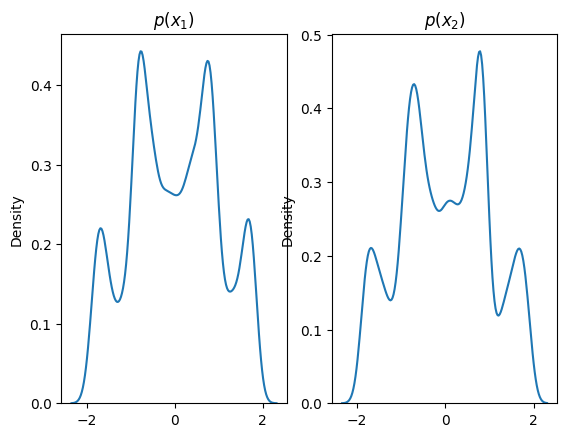

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Create toy dataset of concentric circles
n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

# Plot the joint distribution
plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

# Plot the marginal distributions
plt.subplot(1, 2, 1)
sns.kdeplot(X[:,0], bw_adjust=0.5)
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.kdeplot(X[:,1], bw_adjust=0.5)
plt.title(r'$p(x_2)$')
plt.show()


In [3]:
import pyro.distributions as dist
import pyro.distributions.transforms as T

# Define base distribution
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))

# Define the spline transform
spline_transform = T.Spline(2, count_bins=16)

# Create the transformed distribution
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])


In [4]:
# Convert dataset to torch tensor
dataset = torch.tensor(X, dtype=torch.float)

# Define optimizer
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)

# Training loop
steps = 2001
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print(f'step: {step}, loss: {loss.item()}')


step: 0, loss: 2.624138116836548
step: 200, loss: 1.2846641540527344
step: 400, loss: 1.267996072769165
step: 600, loss: 1.264530062675476
step: 800, loss: 1.262736439704895
step: 1000, loss: 1.2615859508514404


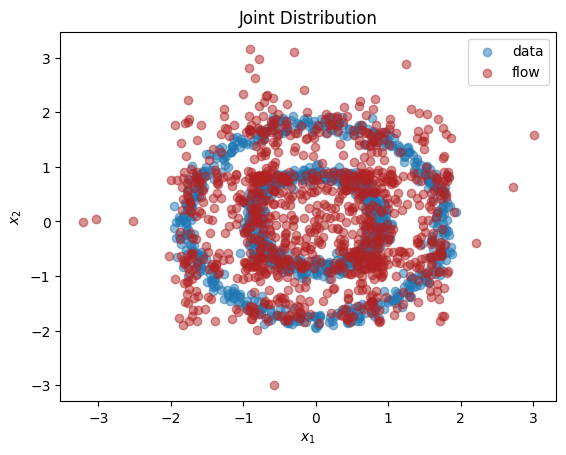

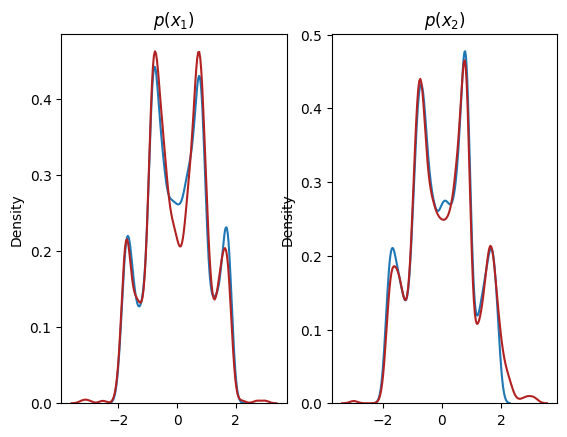

In [5]:
# Sample from the learned distribution
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()

# Plot joint distribution
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

# Plot marginals for comparison
plt.subplot(1, 2, 1)
sns.kdeplot(X[:,0], bw_adjust=0.5, label='data')
sns.kdeplot(X_flow[:,0], bw_adjust=0.5, color='firebrick', label='flow')
plt.title(r'$p(x_1)$')

plt.subplot(1, 2, 2)
sns.kdeplot(X[:,1], bw_adjust=0.5, label='data')
sns.kdeplot(X_flow[:,1], bw_adjust=0.5, color='firebrick', label='flow')
plt.title(r'$p(x_2)$')
plt.show()
